# BodyFat

In [114]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.metrics import r2_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Regression/bodyfat(252, 14).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'bodyfat'
file_name = data_name

x_tr = x_tr.toarray().T
scaler_x = StandardScaler()
scaler_y = StandardScaler()
# y_tr /= np.max(np.abs(y_tr))

# x_tr = (x_tr + 1) / 2
y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]

print(x_tr.shape)
print(x_test.shape)

x_tr = scaler_x.fit_transform(x_tr.T).T
x_test = scaler_x.transform(x_test.T).T
y_tr = scaler_y.fit_transform(y_tr)
y_test = scaler_y.transform(y_test)


dim, num = x_tr.shape
print('of objects:', num)
print('of features', dim)
print(data_name)

(14, 201)
(14, 51)
of objects: 201
of features 14
bodyfat


# K-means cluster centers as inducing inputs

In [9]:
ind_num = 20
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [66]:
cov_params = np.array([1., 2., 1.])

# SVI-L-BFGS-B

In [67]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='L-BFGS-B')

In [68]:
opts = {'maxiter': 50, 'disp': False}
svi_res = svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

In [69]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 'i', freq=1)

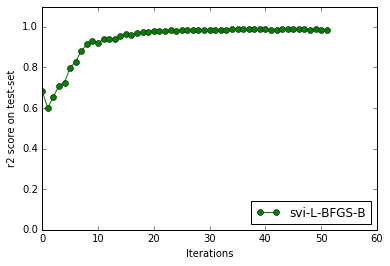

In [70]:
plt.plot(svi_x_lst, svi_y_lst, '-go', label='svi-L-BFGS-B')
plt.ylim([0., 1.1])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [71]:
svi_gp.covariance_obj.get_params()

array([[  4.73673332],
       [ 29.196205  ],
       [  0.24472279]])

## VI

In [72]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPR(model_covariance_obj, method='means', optimizer='L-BFGS-B')

In [73]:
opts = {'maxiter': 20, 'disp': True}
vi_res = vi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

In [74]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 'i', freq=1)

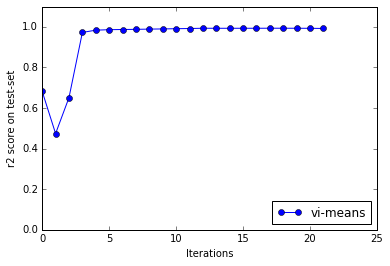

In [75]:
plt.plot(vi_x_lst, vi_y_lst, '-bo', label='vi-means')
plt.ylim([0., 1.1])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [76]:
vi_res.params[1]

array([  0.67122546,  15.45190856,   0.67122546])

In [81]:
vi_y_lst[-1]

0.99223287145570704

## Stochastic SVI
### AdaDelta-Cholesky

In [82]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ch_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='SAG')

In [83]:
opts = {'mydisp': True, 'print_freq': 100, 'step_rate': 0.3,
                'maxiter': 300, 'batch_size':20}
ch_svi_res = ch_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Iteration  100 :
	Gradient norm 1.08565731257
Iteration  200 :
	Gradient norm 9.25855190439
Iteration  300 :
	Gradient norm 0.819727627284


In [84]:
metric = lambda w: ch_svi_gp.get_prediction_quality(w, x_test, y_test)
ch_svi_x_lst, ch_svi_y_lst = ch_svi_res.plot_performance(metric, 'i', freq=5)

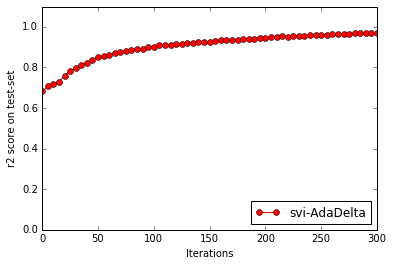

In [85]:
plt.plot(ch_svi_x_lst, ch_svi_y_lst, '-ro', label='svi-AdaDelta')
plt.ylim([0., 1.1])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [73]:
ch_svi_gp.covariance_obj.get_params()

array([[ 1.4647005 ],
       [ 9.08350622],
       [ 0.1640217 ]])

In [86]:
ch_svi_y_lst[-1]

0.97112284223018075

### SG-Natural

In [143]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
n_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural')

In [144]:
opts = {'maxiter':10000, 'batch_size': 20, 'print_freq': 100, 'step0': 5e-4, 'gamma': 0.51}
n_svi_res = n_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 0.0005
	Parameters [ 0.65793397  2.17590116]
Epoch  100 :
	Step: 4.77496293011e-05
	Parameters [ 0.68443399  3.60609804]
Epoch  200 :
	Step: 3.35308610951e-05
	Parameters [ 0.72473075  3.93555759]
Epoch  300 :
	Step: 2.72670506224e-05
	Parameters [ 0.73663017  4.16371078]
Epoch  400 :
	Step: 2.35461230221e-05
	Parameters [ 0.7476564   4.34457321]
Epoch  500 :
	Step: 2.10133503824e-05
	Parameters [ 0.76877336  4.48912156]
Epoch  600 :
	Step: 1.91475347616e-05
	Parameters [ 0.77716704  4.62527903]
Epoch  700 :
	Step: 1.76998670376e-05
	Parameters [ 0.77880615  4.74652711]
Epoch  800 :
	Step: 1.65346159109e-05
	Parameters [ 0.79650613  4.85815608]
Epoch  900 :
	Step: 1.55706350086e-05
	Parameters [ 0.80725188  4.95726309]
Epoch  1000 :
	Step: 1.47560461333e-05
	Parameters [ 0.82111916  5.04791359]
Epoch  1100 :
	Step: 1.40559348303e-05
	Parameters [ 0.83116599  5.13713975]
Epoch  1200 :
	Step: 1.34458285394e-05
	Parameters [ 0.85472298  5.21985416]
Epoch  1300 :
	Step: 1

In [145]:
metric = lambda w: n_svi_gp.get_prediction_quality(w, x_test, y_test)
n_svi_x_lst, n_svi_y_lst = n_svi_res.plot_performance(metric, 'i', freq=10)

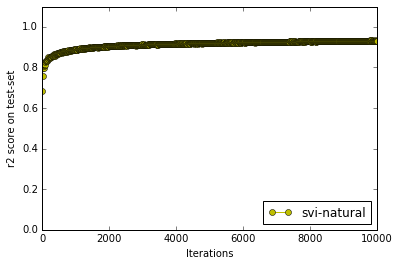

In [146]:
plt.plot(n_svi_x_lst, n_svi_y_lst, '-yo', label='svi-natural')
plt.ylim([0., 1.1])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

# Save results

In [147]:
np.save('../plots/regression_revision/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/regression_revision/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/regression_revision/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/regression_revision/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/regression_revision/'+ data_name +'_ad_x.npy', ch_svi_x_lst)
np.save('../plots/regression_revision/'+ data_name +'_ad_y.npy', ch_svi_y_lst)
np.save('../plots/regression_revision/'+ data_name +'_sg_x.npy', n_svi_x_lst)
np.save('../plots/regression_revision/'+ data_name +'_sg_y.npy', n_svi_y_lst)

#SVM test

In [115]:
svm = SVR(C=0.5)
svm.fit(x_tr.T, y_tr[:, 0])

SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [116]:
pred = svm.predict(x_test.T)
r2_score(y_test, pred)

0.88704056762154104